In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import patsy
import pandas as pd
import numpy as np

from src.policy import Policy, ActionValuePolicy
from src.reward import Reward
from src.transition import Transition
from src.initial_state import InitialState
from src.mdp import MDP
from src.ps_models import construct_PS_model
from src.q_models import construct_Q_model
from src.estimators import VSUP_DR. VSSL_DR
from src.imputation_models import ImputationLasso

from tqdm import tqdm
import seaborn as sns

# Config

In [2]:
class Config():

    # Basics
    num_state_features = 5
    num_actions = 3
    num_timesteps = 2

    # Initial state distribution
    P0_mean = np.zeros(num_state_features)
    P0_cov = np.eye(num_state_features)

    # Transition function cov
    P_cov = np.eye(num_state_features)

    # Models
    ps_model_name = 'LinearPS'
    q_model_name = 'LSTDQ'

    # Simulation related params
    start_seed = 2021
    n_simulations = 10
    mc_samples = 10000

    # VSUP SSL
    labeled_data_prop = 0.3
    cv_splits = 5

config = Config()

# MDP

In [3]:
def init_weights(formula):
    X = patsy.dmatrix(formula, data=balanced_data, return_type='dataframe')
    weights = pd.Series(np.random.uniform(-2, 2, X.shape[1]))
    weights.index = X.columns
    
    return weights

In [4]:
np.random.seed(config.start_seed)

# Define the MDP
# Initial State Distribution
P0 = InitialState(
    num_state_features=config.num_state_features,
    mean=config.P0_mean, 
    cov = config.P0_cov)

balanced_data = pd.concat([
    P0(config.num_actions),
    pd.DataFrame([str(a) for a in range(config.num_actions)], columns=['A'])], axis=1)
levels = list(balanced_data['A'].unique())

# Reward function
reward_formula = f"(0 + C(A, Treatment(reference='0'), levels={levels})) + (0 + C(A, Treatment(reference='0'), levels={levels})):({'+'.join(P0(1).columns)})"
reward_weights = init_weights(reward_formula)
R = Reward(
    formula=reward_formula,
    weights=reward_weights,
)

# Transition function
transition_formula = f"(0 + C(A, Treatment(reference='0'), levels={levels}))"
transition_weights = pd.concat([init_weights(transition_formula)]*config.num_state_features, axis=1)
transition_weights.columns = [f'S{s}' for s in range(config.num_state_features)]
P = Transition(formula=transition_formula, weights=transition_weights, cov=config.P_cov)

# Policy
policy_formula = '+'.join(P0(1).columns)
policy_weights = pd.concat([init_weights(policy_formula) for a in range(0, config.num_actions)], axis=1)
policy_weights.columns = [f'A{a}' for a in range(config.num_actions)]
policy_weights['A0'] = 0
Pi_b = Policy(formula=policy_formula, weights=policy_weights, deterministic=False)

# MDP
M = MDP(P0=P0, R=R, P=P, policy=Pi_b, num_actions=config.num_actions, num_timesteps=config.num_timesteps, num_state_features=config.num_state_features)

# Evaluation Policy

In [5]:
eval_policy_weights = pd.concat([init_weights(policy_formula) for a in range(0,config.num_actions)], axis=1)
eval_policy_weights.columns = [f'A{a}' for a in range(config.num_actions)]
eval_policy_weights['A0'] = 0
eval_policy = Policy(formula=policy_formula, weights=eval_policy_weights, deterministic=True)

In [6]:
mc_estimates = list()
for i in tqdm(range(config.n_simulations)):
    eval_policy_data = M.sample_trajectories_for_policy(config.mc_samples, eval_policy, 
                                                        seed=config.start_seed + 6782 + i) 
    mc_estimates.append(
        sum(eval_policy_data[t]['R'].mean() for t in range(config.num_timesteps)))

100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


In [6]:
q_model_params = {
    'formula': reward_formula,
    'eval_policy': eval_policy
}

ps_model_params = {
    'formula': policy_formula
}

# Supervised estimator

In [8]:
vsup_dr_estimates = list()

for i in tqdm(range(config.n_simulations)):

    # Sample trajectories
    data = M.sample_trajectories(config.mc_samples, seed=config.start_seed+123123+i)

    # Models for Q function and Propensity score
    Q_model = construct_Q_model(model_name=config.q_model_name, model_params=q_model_params)
    Q_model.fit(data=data)

    PS_model = construct_PS_model(model_name=config.ps_model_name, model_params=ps_model_params)
    PS_model.fit(data=data)
    
    # Calculate supervised estimator
    vsup_dr_estimates.append(
        VSUP_DR(data=data, Q_model=Q_model, PS_model=PS_model)
    )

100%|██████████| 10/10 [00:52<00:00,  5.23s/it]


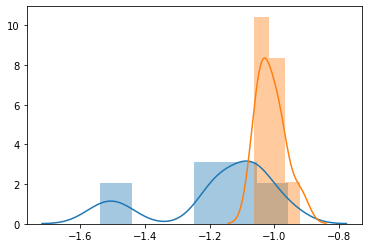

In [9]:
sns.distplot(vsup_dr_estimates)
sns.distplot(mc_estimates)

# Semi supervised estimator

In [7]:
vssl_dr_estimates = list()

for i in tqdm(range(config.n_simulations)):

    # Sample trajectories
    data = M.sample_trajectories(config.mc_samples, seed=config.start_seed+123123+i)

    # Create surrogate variables
    for t in range(config.num_timesteps):
        data[t]['W'] = np.rint(data[t]['R'].values + np.random.normal(loc=0, scale=np.sqrt(2), size=config.mc_samples))

    # Randomly split into labeled and unlabeled data
    labeled_ids = np.random.choice(
        list(range(len(data[0]))),
        size=int(config.labeled_data_prop*len(data[0])), 
        replace=False)

    labeled_data = [df.iloc[labeled_ids].reset_index(drop=True) for df in data]
    unlabeled_data = [df.drop(index=labeled_ids).reset_index(drop=True) for df in data]

    # Models for Q function and Propensity score
    Q_model = construct_Q_model(model_name=config.q_model_name, model_params=q_model_params)
    Q_model.fit(data=labeled_data)

    PS_model = construct_PS_model(model_name=config.ps_model_name, model_params=ps_model_params)
    PS_model.fit(data=data)
    
    # Learn imputation model (Imputation)
    Imputation_model = ImputationLasso(
        cv_splits=config.cv_splits, 
        imputation_features=[f'S{s}' for s in range(config.num_state_features)] + ['A'] + ['W'],
        target='R',
        seed=config.start_seed
    )
    Imputation_model.fit(data=labeled_data)

    # Compute VSSL_DR estimate    
    vssl_dr_estimates.append(
        VSSL_DR(labeled_data=labeled_data, unlabeled_data=unlabeled_data, Q_model=Q_model, PS_model=PS_model, Imputation_model=Imputation_model)
    )

    

  0%|          | 0/10 [00:03<?, ?it/s]


NameError: name 'VSSL_DR' is not defined

In [36]:
# Observed data
obs_data = M.sample_trajectories(config.mc_samples, seed=config.start_seed)

# Create surrogate variables 
for t in range(config.num_timesteps):
    obs_data[t]['W'] = np.rint(obs_data[t]['R'].values + np.random.normal(loc=0, scale=np.sqrt(2), size=obs_data[t].shape[0]))

In [37]:
# Estimate Q function for eval policy
Q_model.fit(obs_data)

# Estimate propensity scores for behavior policy
PS_model.fit(obs_data)

In [38]:
for t in range(config.num_timesteps):
    df = obs_data[t].copy(deep=True)

    if Q_model.eval_policy.deterministic:

        # Predicted action value for eval policy
        df['A'] = Q_model.eval_policy(data=df, timestep=t)
        obs_data[t]['V_eval_(S)'] = Q_model.predict(data=df, timestep=t)

        # Calculate probability of action under eval and behav policy
        obs_data[t]['Pr_eval_(A)'] = (df['A'] == obs_data[t]['A']).astype(int)
        behav_policy_prob_action = PS_model.predict_prob(
            data=obs_data[t], timestep=t)
        behav_policy_prob_action['A'] = obs_data[t]['A']
        obs_data[t]['Pr_(A)'] = behav_policy_prob_action.apply(
            lambda row: row[f'A{row["A"]}'], axis=1
        )
    else:
        raise NotImplementedError

    # Calculate importance sampling ratio
    obs_data[t]['rho'] = obs_data[t]['Pr_eval_(A)'] / obs_data[t]['Pr_(A)']
    if t > 0:
        obs_data[t]['rho'] *= obs_data[t-1]['rho']

## Create surrogate variables

In [39]:
# Randomly split into labeled and unlabeled data
labeled_ids = np.random.choice(list(range(obs_data[0].shape[0])), size=int(config.labeled_data_prop*obs_data[0].shape[0]), replace=False)

labeled_data = [data.iloc[labeled_ids].reset_index(drop=True) for data in obs_data]
unlabeled_data = [data.drop(index=labeled_ids).reset_index(drop=True) for data in obs_data]

## 1. Imputation

In [40]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import KFold

In [41]:
imp_models = list()
imp_features = [f'S{s}' for s in range(config.num_state_features)] + ['A'] + ['W']

for t in range(config.num_timesteps):
    cv = KFold(n_splits=config.cv_splits)
    
    X = labeled_data[t][imp_features]
    y = labeled_data[t]['R']

    R_hat = pd.Series(index=labeled_data[t].index, dtype='float64')
    
    # Model selection
    # Find best parameters using cross validation
    model = LassoCV(cv=config.cv_splits, random_state=config.start_seed, normalize=True).fit(X, y)
    eps = model.eps

    # Getting prediction on every labeled data point
    # Get reward predictions using cross validation (different from earlier)
    imp_models.append([])
    for train_index, test_index in cv.split(X):

        # Train and test val data
        X_val_train, X_val_test = X.iloc[train_index], X.iloc[test_index]
        y_val_train, y_val_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit model
        model = Lasso(alpha=eps, normalize=True)
        model.fit(X_val_train, y_val_train)

        # Predict reward on test val data
        R_hat.iloc[test_index] = model.predict(X_val_test)

        imp_models[t].append(model)
    
    labeled_data[t]['R_hat'] = R_hat
        

## 2. Refitting

In [42]:
bias_coef = list()

for t in range(config.num_timesteps):
    bias_coef.append(
        np.mean(labeled_data[t]['rho']*(labeled_data[t]['R'] - labeled_data[t]['R_hat'] ))
    )

## 3. Projection

In [43]:
for t in range(config.num_timesteps):
    R_hat = list()
    for k in range(config.cv_splits):
        R_hat.append(imp_models[t][k].predict(unlabeled_data[t][imp_features]))
    unlabeled_data[t]['R_hat'] = np.vstack(R_hat).mean(axis=0)
    unlabeled_data[t]['mu_hat'] = (unlabeled_data[t]['R_hat']*unlabeled_data[t]['rho']) + bias_coef[t]

# Estimate

In [44]:
VSSL_DR = unlabeled_data[0]['V_eval_(S)'].mean()
for t in range(config.num_timesteps):
    VSSL_DR += unlabeled_data[t]['mu_hat'].mean()

    if t < (config.num_timesteps-1):
        VSSL_DR -= (unlabeled_data[t]['rho'].clip(0, 1000) *\
            (unlabeled_data[t]['V_eval_(S)'] - unlabeled_data[t+1]['V_eval_(S)'])).mean()
                    
    else:
        VSSL_DR -= (unlabeled_data[t]['rho'].clip(0, 1000) *\
            unlabeled_data[t]['V_eval_(S)']).mean()

VSSL_DR

-1.0227235238028713

In [22]:
VSSL_DR

-1.0052090577778887

In [33]:
VSUP_DR(unlabeled_data, Q_model, PS_model)

-1.0296569093835908

In [34]:
unlabeled_data[t]

,S0,S1,S2,S3,S4,A,R,W,V_eval_(S),Pr_eval_(A),Pr_(A),rho,R_hat,mu_hat
0,-0.157295,-0.388666,-0.176992,0.078131,-1.226940,1,-0.639847,-0.639847,-0.153891,1,0.388932,4.74903,-0.668163,-3.102681
1,1.697340,3.032601,2.464066,3.640915,1.590993,2,1.948491,1.948491,1.214421,1,0.999350,0.00000,1.817098,0.022570
2,-0.956179,-0.206530,-0.250608,0.539794,-0.229499,2,2.601532,2.601532,-0.360394,0,0.800944,0.00000,2.444132,0.022570
3,0.898899,-1.994645,-0.270787,-2.935612,1.154672,0,5.601776,5.601776,-5.123701,0,0.869884,0.00000,5.324895,0.022570
4,2.073542,5.591125,1.823354,1.626206,1.538596,2,3.486335,3.486335,7.935876,0,0.989604,0.00000,3.293699,0.022570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.268489,3.841374,2.482165,2.492351,1.534162,2,4.605025,4.605025,4.420862,1,0.998525,0.00000,4.367838,0.022570
69996,0.015480,0.503965,2.491706,1.444873,0.123380,2,0.960349,0.960349,2.207081,1,0.425276,0.00000,0.868308,0.022570
69997,0.108070,1.175278,0.702642,3.293904,1.105775,2,1.098109,1.098109,-0.061115,0,0.999204,0.00000,1.000581,0.022570
69998,0.502841,1.694724,2.184746,3.351415,0.324994,2,3.251712,3.251712,3.161411,1,0.990157,0.00000,3.068420,0.022570


In [7]:
Q_function_formula = reward_formula

In [9]:
models = list()
for t in range(config.num_timesteps-1, -1, -1):

    df = obs_data[t]

    # Target
    if t == (config.num_timesteps-1):
        df['y'] = df['R']
    else:
        df['y'] = df['R'] + pred_future_value

    # Fit model
    model = smf.ols(formula='y ~ ' + Q_function_formula, data=df).fit()
    models.append(model)

    # Find the value for the action that would have been taken by the eval policy
    df_copy = df.copy(deep=True)        
    df_copy['A'] = eval_policy(df_copy)
    pred_future_value = model.predict(df_copy)

models = models[::-1]

# Q Learning

In [10]:
# Q_function_formula = reward_formula

In [11]:
# models = list()
# for t in range(config.num_timesteps-1, -1, -1):

#     df = obs_data[t]

#     # Target
#     if t == (config.num_timesteps-1):
#         df['y'] = df['R']
#     else:
#         df['y'] = df['R'] + max_value

#     # Fit model
#     model = smf.ols(formula='y ~ ' + Q_function_formula, data=df).fit()
#     models.append(model)

#     # Find the predicted value of each action
#     df_copy = df.copy(deep=True)        
#     pred_value = []
#     for a in range(config.num_actions):
#         df_copy['A'] = str(a)
#         pred_value.append(model.predict(df_copy))
#     pred_value = pd.concat(pred_value, axis=1)
#     pred_value.columns = columns=[f'A{d}' for d in range(config.num_actions)]

#     # Find the maximum predicted value
#     max_value = pred_value.max(axis=1)

# models = models[::-1]

# Propensity Score Models

In [12]:
PS_model = policy_formula

ps_models = []
for t in range(0, config.num_timesteps, 1):
    ps_model = smf.mnlogit('A ~ ' + PS_model, data=obs_data[t].astype({'A': int}))
    ps_model = ps_model.fit(method='ncg') 
    ps_models.append(ps_model)

    print(f"Accuracy {t}: {(ps_model.predict(obs_data[t]).values.argmax(axis=1) == obs_data[t]['A'].astype(int)).mean()}")

Optimization terminated successfully.
         Current function value: 0.709655
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 16
         Hessian evaluations: 8
Accuracy 0: 0.74269
Optimization terminated successfully.
         Current function value: 0.501219
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11
Accuracy 1: 0.80284
Optimization terminated successfully.
         Current function value: 0.395425
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 24
         Hessian evaluations: 12
Accuracy 2: 0.84146
Optimization terminated successfully.
         Current function value: 0.369989
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 26
         Hessian evaluations: 13
Accuracy 3: 0.85038
Optimization terminated successfully.
         Current function value: 0.326590
         Iterations: 12

In [22]:
ps_model.predict(obs_data[0])

,0,1,2,3,4
0,0.055942,0.758886,0.047381,0.036914,0.100877
1,0.252592,0.091058,0.132222,0.059890,0.464238
2,0.002592,0.000490,0.002254,0.125785,0.868879
3,0.005362,0.017440,0.000951,0.021076,0.955171
4,0.277423,0.013168,0.327861,0.098501,0.283047
...,...,...,...,...,...
99995,0.079819,0.845222,0.018249,0.024993,0.031717
99996,0.045781,0.775983,0.091978,0.064982,0.021277
99997,0.058307,0.903005,0.035567,0.001879,0.001242
99998,0.026394,0.002616,0.004953,0.033875,0.932163


# Eval Policy Value 

In [13]:
def calculat_avg_reward(data):
    reward = np.zeros(data[0].shape[0])
    for t in range(len(data)):
        reward += data[t]['R']
    
    return reward.mean()

In [14]:
# optimal_policy = ActionValuePolicy(models=models, num_actions=config.num_actions)

## 1. Sampling

In [21]:
# optimal_policy_data = M.sample_trajectories_for_policy(10000, optimal_policy,seed=config.seed + 10) 
eval_policy_data = M.sample_trajectories_for_policy(100000, eval_policy, seed=config.seed + 120) 

print(calculat_avg_reward(eval_policy_data))

-4.910013447537342


In [16]:
# behav_policy_data = M.sample_trajectories(10000, seed=2020) 

# print(calculat_avg_reward(behav_policy_data))

## 2. VSUP

In [17]:
behav_policy = list()
for t in range(config.num_timesteps):
    ps_model_weights = ps_models[t].params
    ps_model_weights.rename({a: f'A{a+1}' for a in ps_model_weights.columns}, axis=1, 
    inplace=True)
    ps_model_weights['A0'] = 0
    ps_model_weights = ps_model_weights[[f'A{a}' for a in range(config.num_actions)]]
    
    behav_policy.append(
        Policy(formula=PS_model, weights=ps_model_weights, deterministic=False)
    )

In [18]:
# Hack
try:
    for t in range(config.num_timesteps):
        for col in [f'Pr(A{a})' for a in range(config.num_actions)]:
            del obs_data[t][col]
except KeyError:
    pass

# # Calculate value of each state under behavior policy
# for t in range(config.num_timesteps):
#     pred_action_value = optimal_policy.calculate_action_value(obs_data[t], t)
#     pred_action_prob = behav_policy[t].calculate_action_prob(obs_data[t], t)
    
#     # pred_value = (pred_action_value.rename({col: col[5:-1] for col in pred_action_value.columns}, axis=1) * pred_action_prob).sum(axis=1)
#     pred_value = pred_action_value.max(axis=1)
    
#     obs_data[t]['V(S)'] = pred_value
#     obs_data[t] = pd.concat([obs_data[t], pred_action_prob.rename({col: f'Pr({col})' for col in pred_action_prob.columns}, axis=1)], axis=1)

# Calculate value of each state under behavior policy
for t in range(config.num_timesteps):
    df = obs_data[t].copy(deep=True)

    # Predicted action value for eval policy
    df['A'] = eval_policy(df, t)
    obs_data[t]['V(S)'] = models[t].predict(df)
    obs_data[t]['eval_A'] = df['A']
    
    # Prob of action taken by eval policy under behav policy
    pred_action_prob = behav_policy[t].calculate_action_prob(obs_data[t], t)
    obs_data[t] = pd.concat([obs_data[t], pred_action_prob.rename({col: f'Pr({col})' for col in pred_action_prob.columns}, axis=1)], axis=1)

In [19]:
# Calculate importance sampling weights
# for t in range(config.num_timesteps):
#     rho = obs_data[t].apply(lambda row: row[f'Pr(A{row["A"]})'], axis=1)
#     rho *= (obs_data[t]['A'] == optimal_policy(obs_data[t], t)).astype(int)

#     if t > 0:
#         rho *= obs_data[t-1]['rho']
    
#     obs_data[t]['rho'] = rho

for t in range(config.num_timesteps):
    rho = (obs_data[t]['A'] == obs_data[t]['eval_A']).astype(int)
    rho /= obs_data[t].apply(lambda row: row[f'Pr(A{row["A"]})'], axis=1)

    if t > 0:
        rho *= obs_data[t-1]['rho']
    try:
        del obs_data[t]['rho'] 
    except KeyError:
        pass
    
    obs_data[t]['rho'] = rho

In [20]:
VSUP_DR = obs_data[0]['V(S)'].mean()
for h in range(0, config.num_timesteps):
    if h < (config.num_timesteps-1):
        VSUP_DR += (obs_data[h]['rho'] * (obs_data[h]['R']-obs_data[h]['V(S)'] +obs_data[h+1]['V(S)'])).mean()
    else:
        VSUP_DR += (obs_data[h]['rho'] * (obs_data[h]['R'] -obs_data[h]['V(S)'])).mean()
print(VSUP_DR)

-4.928404770082305


In [ ]:
# Predict probability of each action at every timestep

# Predict Q(s, a) at every timestep

# Calculate V_st

In [20]:
# Timestep 0
t = 0
data_copy = obs_data[t].copy(deep=True)
pred_value = pd.DataFrame()
for a in range(config.num_actions):
    data_copy['A'] = str(a)
    pred_value[f'A{a}'] = models[t].predict(data_copy)


In [20]:
pred_value

0       -0.566629
1        1.216454
2        1.226768
3        3.635046
4        3.041791
           ...   
99995    1.270736
99996    3.114499
99997   -1.171686
99998    3.044376
99999   -5.170365
Length: 100000, dtype: float64

In [125]:
ps_models[1]

In [ ]:
# Replace Pi by PS_model

In [123]:
ps_models[1]

In [124]:
alt_policy = optimal_policy

VSUP_DR  = 0
for n, i in enumerate(list(np.random.randint(0, obs_data[0].shape[0], 1000))):
    VSUP_DR += models[0].predict(obs_data[0].iloc[[i]]).iloc[0]
    for t in range(config.num_timesteps):
        # VSUP_DR += models[t].predict(obs_data[t].iloc[[i]]).iloc[0]
        rho_h = 1
        for h in range(t):
            # pi_a_s = optimal_policy()

            if alt_policy.deterministic:
                alt_action = alt_policy(obs_data[h].iloc[[i]], h).iloc[0]
                actual_action = obs_data[h].iloc[[i]].iloc[0]['A']
                pi_a_s = 0 if (alt_action != actual_action) else 1
            else:
                raise NotImplementedError

            pib_a_s = Pi.calculate_action_prob(obs_data[h].iloc[i], h)
            pib_a_s = pib_a_s['A' + actual_action].iloc[0]
            
            rho_h *=  pi_a_s / pib_a_s
        

        td_target = obs_data[t].iloc[i]['R']
        # td_target = obs_data[t].iloc[i]['R'] + sum(
            # obs_data[f].iloc[i]['R'] for f in range(t+1, config.num_timesteps))
        try:
            td_target += models[t+1].predict(obs_data[t+1].iloc[[i]]).iloc[0]
        except IndexError:
            pass
        delta_td = td_target - models[t].predict(obs_data[t].iloc[[i]]).iloc[0]
        VSUP_DR += rho_h*delta_td

    
    if n % 50 == 0:    
        print(VSUP_DR/(n+1))

-5.744099948774931
-1.6709106265556115
-2.212764721426827
-2.4873926118283864


KeyboardInterrupt: 

[72571,
 78448,
 97397,
 43355,
 37141,
 35762,
 42722,
 61476,
 52303,
 76092,
 2551,
 62937,
 68918,
 36265,
 50981,
 54988,
 2277,
 66829,
 51182,
 94672,
 10351,
 23142,
 81897,
 55025,
 92717,
 75357,
 78935,
 30583,
 54906,
 61857,
 95565,
 91716,
 71308,
 47830,
 55060,
 30719,
 78603,
 39907,
 8066,
 7480,
 36349,
 25495,
 58866,
 14047,
 16319,
 5773,
 42922,
 79224,
 87876,
 76657,
 683,
 96398,
 17798,
 95887,
 45839,
 12271,
 73138,
 87310,
 9554,
 28925,
 32323,
 62322,
 38433,
 68540,
 46123,
 17158,
 21428,
 17180,
 72458,
 91467,
 30996,
 93430,
 37370,
 78082,
 64497,
 93568,
 94595,
 11752,
 1834,
 89708,
 43523,
 60448,
 23860,
 56245,
 6760,
 57038,
 86785,
 33244,
 29748,
 92264,
 41373,
 97222,
 49786,
 33248,
 18955,
 99986,
 4862,
 94350,
 73104,
 45634]

In [17]:
 obs_data[h].iloc[[i]]

,S0,S1,S2,S3,S4,A,R,y
0,1.488609,0.676011,-0.418451,-0.806521,0.555876,0,3.882888,8.405077


In [40]:
obs_data[h].iloc[i]['A']

'0'

0    0
dtype: object

In [47]:
pib_a_s

,A0,A1,A2
0,0.073779,0.549885,0.376337


In [55]:
from typing import Dict

import numpy as np
from numpy.random import multinomial, multivariate_normal, uniform, normal
from scipy.special import softmax
import pandas as pd
import patsy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

seed = 2021
np.random.seed(seed)

In [66]:
# Config
num_timesteps = 5
num_actions = 3
state_dim = 5
size = 10000

# Mean of MVN for drawing state at timestep t
mu0 = np.zeros(state_dim)
sigma = np.eye(state_dim)

# Coefficient for each action in the transition function
gamma = uniform(-2, 2, size=num_actions)

# Regression coefficients for outcome
beta = uniform(-2, 2, size=(state_dim+1)*num_actions*num_timesteps).reshape(num_timesteps, num_actions, state_dim+1)
# beta_a = uniform(-2, 2, size=num_timesteps*num_actions).reshape(num_timesteps, num_actions)
# beta = uniform(-2, 2, size=state_dim*num_actions).reshape(num_actions, state_dim)
# beta_a = uniform(-2, 2, size=num_actions)

# Regression coefficients for treatment 
# phi = uniform(-5, 2, size=(state_dim+1)*(num_actions-1)*num_timesteps).reshape(num_timesteps, num_actions-1, state_dim+1)
# phi = np.concatenate([np.zeros((num_timesteps, 1, state_dim+1)), phi], 1)
phi = uniform(-2, 2, size=(state_dim+1)*(num_actions-1)).reshape(num_actions-1, state_dim+1)
phi = np.concatenate([phi, np.zeros((1, state_dim+1))], 0)

print("gamma", gamma.shape)
print("beta", beta.shape)
print("phi", phi.shape)
print("mu0", mu0.shape)
print("sigma", sigma.shape)

gamma (3,)
beta (5, 3, 6)
phi (3, 6)
mu0 (5,)
sigma (5, 5)


In [67]:
data = list()

for t in range(num_timesteps):
    
    # Generate state
    if t == 0:
        S_t = multivariate_normal(mu0, sigma, size=size)
    else:
        S_t = np.vstack([multivariate_normal(S_tminus1[i] + A_tminus1[i]@gamma, sigma, size=1) for i in range(size)])
    S_tdash = np.concatenate([np.ones((size, 1)), S_t], 1)

    # Generate action
    pvals = softmax(S_tdash @ phi.T, axis=1)
    A_t = np.vstack([multinomial(n=1, pvals=pvals[i], size=1) for i in range(size)])
    
    # Generate reward
    mean_R_tplus1 = np.vstack([(S_tdash@beta[t, a]) * (A_t[:, a]) for a in range(num_actions)]).sum(axis=0)
    R_tplus1 = normal(loc=mean_R_tplus1, scale=1)
    
    # Convert to dataframe
    data.append(
        pd.concat([
            pd.DataFrame(S_t, columns=[f'S{d}' for d in range(1, state_dim + 1)]),
            pd.DataFrame(np.argmax(A_t, axis=1), columns=['A']).astype(object),
            pd.DataFrame(R_tplus1, columns=['R'])
        ], axis=1)
    )

    # Transition
    A_tminus1 = A_t
    S_tminus1 = S_t

    print(A_t.sum(axis=0))

# Ensure one action of each type!
# TO DO #

[2728 4323 2949]
[4199 3948 1853]
[4855 3679 1466]
[5230 3435 1335]
[5526 3311 1163]


# Q-learning

In [68]:
Q_function_model = f"A*({'+'.join(f'S{d}' for d in range(1, state_dim+1))})"
print(Q_function_model)

A*(S1+S2+S3+S4+S5)


In [69]:
models = list()

for t in range(num_timesteps-1, -1, -1):

    df = data[t]

    # Target
    if t == (num_timesteps-1):
        df['y'] = df['R']
    else:
        df['y'] = df['R'] + max_value

    # Fit model
    model = smf.ols(formula='y ~ ' + Q_function_model, data=df).fit()
    models.append(model)

    # Find the predicted value of each action
    df_copy = df.copy(deep=True)        
    pred_value = []
    for a in range(num_actions):
        df_copy['A'] = a
        pred_value.append(model.predict(df_copy))
    pred_value = pd.concat(pred_value, axis=1)
    pred_value.columns = columns=[f'A{d}' for d in range(num_actions)]

    # Find the maximum predicted value
    max_value = pred_value.max(axis=1)

models = models[::-1]

# Propensity score models

In [70]:
PS_model = f"{'+'.join(f'S{d}' for d in range(1, state_dim+1))}"

ps_models = []
for t in range(0, num_timesteps, 1):
    ps_model = smf.mnlogit('A ~ ' + PS_model, data=data[t].astype({'A': int}))
    ps_model = ps_model.fit(method='ncg')
    ps_models.append(ps_model)

    print(f"Accuracy {t}: {(ps_model.predict(data[t]).values.argmax(axis=1) == data[t]['A']).mean()}")

Optimization terminated successfully.
         Current function value: 0.577084
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 16
         Hessian evaluations: 8
Accuracy 0: 0.7515
Optimization terminated successfully.
         Current function value: 0.311172
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 18
         Hessian evaluations: 9
Accuracy 1: 0.8717
Optimization terminated successfully.
         Current function value: 0.201014
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11
Accuracy 2: 0.9147
Optimization terminated successfully.
         Current function value: 0.149221
         Iterations: 11
         Function evaluations: 12
         Gradient evaluations: 22
         Hessian evaluations: 11
Accuracy 3: 0.9384
Optimization terminated successfully.
         Current function value: 0.116937
         Iterations: 12
     

# Optimal value function estimation

In [71]:
def get_dummies(x, num_levels):
    dummy_data = np.zeros((x.shape[0], num_levels))
    for i, xi in enumerate(x):
        dummy_data[i, xi] = 1
    return dummy_data

In [72]:
optimal_policy_data = list()

for t in range(num_timesteps):
    
    # Generate state
    if t == 0:
        S_t = multivariate_normal(mu0, sigma, size=size)
    else:
        S_t = np.vstack([multivariate_normal(S_tminus1[i] + A_tminus1[i]@gamma, sigma, size=1) for i in range(size)])
    S_tdash = np.concatenate([np.ones((size, 1)), S_t], 1)
    
    # Choose action
    # Find the predicted value of each action
    df_copy = pd.DataFrame(S_t, columns=[f'S{d}' for d in range(1, state_dim + 1)])
    pred_value = []
    for a in range(num_actions):
        df_copy['A'] = a
        pred_value.append(models[t].predict(df_copy))
    pred_value = pd.concat(pred_value, axis=1)
    pred_value.columns = columns=[f'A{d}' for d in range(num_actions)]
    # Find the best action
    A_t = get_dummies(pred_value.values.argmax(axis=1), num_actions)
    
    # Generate reward
    mean_R_tplus1 = np.vstack([(S_tdash@beta[t, a]) * (A_t[:, a]) for a in range(num_actions)]).sum(axis=0)
    R_tplus1 = normal(loc=mean_R_tplus1, scale=1)
    
    # Convert to dataframe
    optimal_policy_data.append(
        pd.concat([
            pd.DataFrame(S_t, columns=[f'S{d}' for d in range(1, state_dim + 1)]),
            pd.DataFrame(np.argmax(A_t, axis=1), columns=['A']).astype(object),
            pd.DataFrame(R_tplus1, columns=['R'])
        ], axis=1)
    )

    # Transition
    A_tminus1 = A_t
    S_tminus1 = S_t

# Ensure one action of each type!
# TO DO #

In [73]:
reward = np.zeros(size)
for t in range(num_timesteps):
    reward += optimal_policy_data[t]['R']
print(reward.mean())

21.05172275943445


In [74]:
reward = np.zeros(size)
for t in range(num_timesteps):
    reward += data[t]['R']
print(reward.mean())

-8.14064575080257


In [23]:
model.predict(df_copy)

0       430.375069
1       301.294152
2       328.358626
3       514.523905
4       225.653631
           ...    
9995    299.465630
9996    334.353243
9997    389.647749
9998    510.292456
9999    309.699211
Length: 10000, dtype: float64